# Energy balance from Ketura paper

The objective of this script is to create the parameters necessary for the energy closure calculation

In [1]:
import pandas as pd
import openpyxl
import numpy as np
import glob
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from scipy import signal
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from plotnine.data import mtcars

### Input and output paths

In [2]:
project_path = 'D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/'   # Weizmann desktop
#project_path = 'C:/Users/rafas/Dropbox/Doutorado/Working/Ketura/'     # notebook
input_path   = project_path + '01_data/'
output_path  = project_path + '02_output/'
graphs_path  = project_path + '03_graphs/'

# Functions

In [3]:
# Loads all data in the folder
def load_all_data(path):
    file_list = sorted(glob.glob(path + '*corr.csv', recursive=True))

    data_list = []
    for filename in file_list:
        fn_without_path = filename.replace(path[:-1], "")[1:]
        print("Loading", fn_without_path)
        
        temp = pd.read_csv(filename)
        # attribute Season and Ecosystem
        temp['Ecosystem'] = fn_without_path.split(' ')[2]
        temp['Year'] = fn_without_path.split(' ')[5]
        temp['Season'] = fn_without_path.split(' ')[4]
        temp['DateTime'] = pd.to_datetime(temp['DateTime'], format='%Y-%m-%d %H:%M:%S', utc=True)
        
        data_list.append(temp)
        
    # Combine all the read data
    df = pd.concat(data_list, axis=0, ignore_index=True)
    
    display (df)
    return(df)
    
    
def rename_and_convert_desert(df):
    
    # Rename
    df.rename(columns={'H_mdsgf_SH': 'H'}, inplace=True)
    df.rename(columns={'LE_mdsgf_SLE': 'LE'}, inplace=True)
    df.rename(columns={'LW_IN_average_corr': 'LWin'}, inplace=True)
    df.rename(columns={'LW_OUT_average_corr': 'LWout'}, inplace=True)
    df.rename(columns={'SW_IN_average': 'SWin'}, inplace=True)
    df.rename(columns={'SW_OUT_average': 'SWout'}, inplace=True)
           
    # Convert columns to float
    df['H']  = pd.to_numeric(df['H'], downcast="float")
    df['LE'] = pd.to_numeric(df['LE'], downcast="float")
    df['LWin']  = pd.to_numeric(df['LWin'], downcast="float")
    df['LWout'] = pd.to_numeric(df['LWout'], downcast="float")
    df['SWin']  = pd.to_numeric(df['SWin'], downcast="float")
    df['SWout'] = pd.to_numeric(df['SWout'], downcast="float")

    # Calculating Rn
    df['Rn'] = df['SWin'] - df['SWout'] + df['LWin'] - df['LWout']
    
    # Calculating PVe (electricity)
    df['PVe'] = df['SWin'] * 0.064
    
    # Create H + LE + PVe
    df['H_LE_PVe'] = df['H'] + df['LE'] + df['PVe']
    
    # Create EBR (energy balance ratio - Mahrt 1998)
    df['EBR'] = df['H_LE_PVe']/df['Rn'] 
    
    # Keep only relevant columns
    df = df[['DateTime','Season','Year','Ecosystem','H','LE','PVe','Rn','H_LE_PVe']]
    # define mid-day
    #df = df.loc[(df['DateTime'].dt.hour >= 11) & (df['DateTime'].dt.hour < 13)]  
         
    return(df)

def rename_and_convert_drone(df):
    
    # Rename
    df.rename(columns={'H_mdsgf_SH': 'H'}, inplace=True)
    df.rename(columns={'LE_mdsgf_SLE': 'LE'}, inplace=True)
    df.rename(columns={'LW_IN_average_corr': 'LWin'}, inplace=True)
    df.rename(columns={'LWout_corr': 'LWout'}, inplace=True)
    df.rename(columns={'SW_IN_average': 'SWin'}, inplace=True)

       
    # Convert columns to float
    df['H']  = pd.to_numeric(df['H'], downcast="float")
    df['LE'] = pd.to_numeric(df['LE'], downcast="float")
    df['LWin']  = pd.to_numeric(df['LWin'], downcast="float")
    df['LWout'] = pd.to_numeric(df['LWout'], downcast="float")
    df['SWin']  = pd.to_numeric(df['SWin'], downcast="float")

    # Estimating SWout based on the fixed albedo value from March 2018 (0.23)
    
    df['SWout'] = df['SWin']*0.23

    # Calculating Rn
    df['Rn'] = df['SWin'] - df['SWout'] + df['LWin'] - df['LWout']
    
    # Calculating PVe (electricity)
    df['PVe'] = df['SWin'] * 0.064
    
    # Create H + LE + PVe
    df['H_LE_PVe'] = df['H'] + df['LE'] + df['PVe']
    
    # Create EBR (energy balance ratio - Mahrt 1998)
    df['EBR'] = df['H_LE_PVe']/df['Rn'] 
    df['EBR'] = df['EBR'].round(2)
    df['Ecosystem'] = 'PV field'
    df['Year'] = df['DateTime'].dt.year
    df['Season'] = df['DateTime'].dt.month

    
    # Keep only relevant columns
    df = df[['DateTime','Season','Year','Ecosystem','H','LE','PVe','Rn','H_LE_PVe','EBR']]
    # define mid-day
    #df = df.loc[(df['DateTime'].dt.hour >= 11) & (df['DateTime'].dt.hour < 13)]  
         
    return(df)

def EBR_calc (temp, Ecosystem, Season):
    
    temp = temp.loc[(temp['Ecosystem'] == Ecosystem) & (temp['Season'] == Season)].copy()
      
    temp = temp.dropna()
    
    # Keep only relevant columns
    EBR_df = temp[['DateTime','Season','Year','Ecosystem','H_LE_PVe','Rn']]
    
    display (EBR_df)
    
    return (EBR_df)

def diurnal_sum(temp):
    temp = temp.copy()
    
    # creating 'Time' column
    temp['Day'] = temp['DateTime'].dt.strftime('%Y-%m-%d')
    
    # Make mean and std dev
    df_grouped = temp.groupby(['Ecosystem','Season','Day','Year']).agg(['sum','count'])
    df_grouped.reset_index(inplace = True)
    df_grouped.columns = ['_'.join(col).strip('_') for col in df_grouped.columns.values]
    
    # Remove days where not all half-hours are available
    df_grouped.drop(df_grouped[df_grouped['H_LE_PVe_count'] < 48].index, inplace=True)
    # Cleaning up
    df_grouped.drop('Day', axis=1, inplace=True)
    
    #Creating EBR
    df_grouped['EBR'] = df_grouped['H_LE_PVe_sum']/df_grouped['Rn_sum'] 
    
    return(df_grouped)

def diurnal_mean(temp):
    
    temp = temp.copy()
    
    # creating 'Time' column
    temp['Day'] = temp['DateTime'].dt.strftime('%Y-%m-%d')
    
    # Make mean and std dev
    df_counts = temp.groupby(['Ecosystem','Season','Day','Year']).agg(['sum','count'])
    df_counts.reset_index(inplace = True)
    df_counts.columns = ['_'.join(col).strip('_') for col in df_counts.columns.values]
    df_means = temp.groupby(['Ecosystem','Season','Day','Year']).mean().reset_index()
    df_stds = temp.groupby(['Ecosystem','Season','Day','Year']).std().reset_index()

    # rename columns
    df_means.rename(columns={'H_LE_PVe': 'H_LE_PVe_mean'}, inplace=True)
    df_means.rename(columns={'Rn': 'Rn_mean'}, inplace=True)
    
    df_stds.rename(columns={'H_LE_PVe': 'H_LE_PVe_sd'}, inplace=True)
    df_stds.rename(columns={'Rn': 'Rn_sd'}, inplace=True)
    
    # Remove days where not all half-hours are available
    df_counts.drop(df_counts[df_counts['H_LE_PVe_count'] < 48].index, inplace=True)
       
    merged_first = df_counts.merge(df_means, on=['Ecosystem','Season','Day','Year'])
    merged = merged_first.merge(df_stds, on=['Ecosystem','Season','Day','Year'])
    
    # Cleaning up
    merged.drop('Day', axis=1, inplace=True)
    
    #Creating EBR
    merged['EBR'] = merged['H_LE_PVe_mean']/merged['Rn_mean'] 
    display(merged)
    
    return(merged)    

In [4]:
desert_df = load_all_data(input_path)

Loading Rafael Ketura Desert Background July 2019 calibration applyied storagek analysis SWLWcorr.csv
Loading Rafael Ketura Desert Background March 2018 storagek analysis SWLWcorr.csv
Loading Rafael Ketura Desert Background October 2018 storagek analysis SWLWcorr.csv
Loading Rafael Ketura Solar Field July 2019 storagek analysis SWLWcorr.csv
Loading Rafael Ketura Solar Field March 2018 storagek analysis SWLWcorr.csv
Loading Rafael Ketura Solar Field October 2018 storagek analysis SWLWcorr.csv


,Unnamed: 0,DateTime,ET_FFA_Unassigned,ET_FFA_fetch,ET_FFA_oof,FCO2_FFA_Unassigned,FCO2_FFA_fetch,FCO2_FFA_oof,FCO2_mdsgf,FCO2_mdsgf_GFQC,...,Year,Month,WS_average,WS_merge,time,delta_LWin_calc,LW_IN_average_corr,delta_LWout_calc,LW_OUT_average_corr,Season
0,0,2019-07-09 20:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,-0.001826,1.0,...,2019,July,NaN,NaN,NaN,-0.380000,407.393000,-0.379615,503.072615,July
1,1,2019-07-09 21:00:00+00:00,NaN,-0.065904,-0.065904,NaN,-0.405516,-0.405516,-0.405516,0.0,...,2019,July,NaN,NaN,NaN,-0.380000,400.309000,-0.380000,497.235000,July
2,2,2019-07-09 21:30:00+00:00,NaN,0.030667,0.030667,NaN,-0.375514,-0.375514,-0.001826,1.0,...,2019,July,NaN,NaN,NaN,-0.380000,396.226000,-0.380000,492.451000,July
3,3,2019-07-09 22:00:00+00:00,NaN,-0.024029,-0.024029,NaN,-0.345513,-0.345513,-0.345513,0.0,...,2019,July,NaN,NaN,NaN,-0.380000,393.476000,-0.380000,488.117000,July
4,4,2019-07-09 22:30:00+00:00,NaN,-0.002193,-0.002193,NaN,-0.052337,-0.052337,-0.052337,0.0,...,2019,July,NaN,NaN,NaN,-0.380000,391.585000,-0.380000,484.428000,July
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1841,1841,2018-11-01 05:30:00+00:00,0.012297,NaN,NaN,2.166620,NaN,NaN,0.342046,0.0,...,2018,October,1.110450,1.110450,1.541050e+09,-0.374329,328.685329,-0.377442,409.699442,October
1842,1842,2018-11-01 06:00:00+00:00,0.001922,NaN,NaN,0.544542,NaN,NaN,0.471272,0.0,...,2018,October,1.933790,1.933790,1.541052e+09,-0.020757,328.489757,-0.262666,411.425666,October
1843,1843,2018-11-01 06:30:00+00:00,0.008814,NaN,NaN,2.687400,NaN,NaN,0.600497,0.0,...,2018,October,1.838250,1.838250,1.541054e+09,0.873860,328.038140,-0.059596,418.312596,October
1844,1844,2018-11-01 07:00:00+00:00,0.004222,NaN,NaN,0.861003,NaN,NaN,0.729723,0.0,...,2018,October,1.570320,1.570320,1.541056e+09,1.744041,330.898376,0.189591,417.273285,October


In [5]:
desert_df = rename_and_convert_desert(desert_df)

display (desert_df)

,DateTime,Season,Year,Ecosystem,H,LE,PVe,Rn,H_LE_PVe
0,2019-07-09 20:30:00+00:00,July,2019,Desert,NaN,NaN,0.000000,-95.718048,NaN
1,2019-07-09 21:00:00+00:00,July,2019,Desert,-16.650749,NaN,0.000000,-96.925995,NaN
2,2019-07-09 21:30:00+00:00,July,2019,Desert,-11.533690,18.102051,0.000000,-96.224976,6.568360
3,2019-07-09 22:00:00+00:00,July,2019,Desert,-21.672520,-17.746120,0.000000,-94.640991,-39.418640
4,2019-07-09 22:30:00+00:00,July,2019,Desert,-13.702280,-0.758002,0.000000,-92.843018,-14.460282
...,...,...,...,...,...,...,...,...,...
1841,2018-11-01 05:30:00+00:00,October,2018,Solar,NaN,NaN,0.036292,-80.702881,NaN
1842,2018-11-01 06:00:00+00:00,October,2018,Solar,NaN,NaN,2.299155,-58.745026,NaN
1843,2018-11-01 06:30:00+00:00,October,2018,Solar,NaN,NaN,8.024705,3.071136,NaN
1844,2018-11-01 07:00:00+00:00,October,2018,Solar,NaN,NaN,13.593861,69.070099,NaN


In [6]:
pv_df = pd.read_csv(input_path + "final_truck_LWout_corrected.csv") 
pv_df['DateTime'] = pd.to_datetime(pv_df['DateTime'], format='%Y-%m-%d %H:%M:%S', utc=True)

pv_df = rename_and_convert_drone(pv_df)

display (pv_df)

,DateTime,Season,Year,Ecosystem,H,LE,PVe,Rn,H_LE_PVe,EBR
0,2018-10-24 12:30:00+00:00,10,2018,PV field,NaN,NaN,44.950401,391.397888,NaN,NaN
1,2018-10-24 13:00:00+00:00,10,2018,PV field,229.105057,NaN,42.811268,372.456421,NaN,NaN
2,2018-10-24 13:30:00+00:00,10,2018,PV field,NaN,NaN,37.407429,314.397766,NaN,NaN
3,2018-10-24 14:00:00+00:00,10,2018,PV field,NaN,NaN,31.689795,252.172119,NaN,NaN
4,2018-10-24 14:30:00+00:00,10,2018,PV field,NaN,NaN,13.342913,59.900024,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
746,2019-07-24 08:00:00+00:00,7,2019,PV field,41.324150,9.484367,26.576065,183.508636,77.384583,0.42
747,2019-07-24 08:30:00+00:00,7,2019,PV field,89.469513,2.602201,33.438721,253.583069,125.510437,0.49
748,2019-07-24 09:00:00+00:00,7,2019,PV field,126.275070,16.564751,40.532032,327.514038,183.371841,0.56
749,2019-07-24 09:30:00+00:00,7,2019,PV field,171.895386,16.148880,54.558231,488.762207,242.602493,0.50


In [7]:
pv_df.loc[pv_df['Season'] == 7, 'Season'] = 'July'
pv_df.loc[pv_df['Season'] == 10, 'Season'] = 'October'

all_df = desert_df.append(pv_df)

all_df.loc[all_df['Ecosystem'] == 'Solar', 'Ecosystem'] = 'PV field'
all_df.loc[all_df['Ecosystem'] == 'Desert', 'Ecosystem'] = 'Desert background'
all_df.loc[all_df['Season'] == 'March', 'Season'] = 'Spring'
all_df.loc[all_df['Season'] == 'October', 'Season'] = 'Autumn'
all_df.loc[all_df['Season'] == 'July', 'Season'] = 'Summer'

display (all_df)

all_df.to_csv(output_path + 'energyclosure_ketura.csv')

#all_df.sum()

,DateTime,Season,Year,Ecosystem,H,LE,PVe,Rn,H_LE_PVe,EBR
0,2019-07-09 20:30:00+00:00,Summer,2019,Desert background,NaN,NaN,0.000000,-95.718048,NaN,NaN
1,2019-07-09 21:00:00+00:00,Summer,2019,Desert background,-16.650749,NaN,0.000000,-96.925995,NaN,NaN
2,2019-07-09 21:30:00+00:00,Summer,2019,Desert background,-11.533690,18.102051,0.000000,-96.224976,6.568360,NaN
3,2019-07-09 22:00:00+00:00,Summer,2019,Desert background,-21.672520,-17.746120,0.000000,-94.640991,-39.418640,NaN
4,2019-07-09 22:30:00+00:00,Summer,2019,Desert background,-13.702280,-0.758002,0.000000,-92.843018,-14.460282,NaN
...,...,...,...,...,...,...,...,...,...,...
746,2019-07-24 08:00:00+00:00,Summer,2019,PV field,41.324150,9.484367,26.576065,183.508636,77.384583,0.42
747,2019-07-24 08:30:00+00:00,Summer,2019,PV field,89.469513,2.602201,33.438721,253.583069,125.510437,0.49
748,2019-07-24 09:00:00+00:00,Summer,2019,PV field,126.275070,16.564751,40.532032,327.514038,183.371841,0.56
749,2019-07-24 09:30:00+00:00,Summer,2019,PV field,171.895386,16.148880,54.558231,488.762207,242.602493,0.50


In [8]:
diurnal_mean_ketura_df = diurnal_mean(all_df)

,Ecosystem,Season,Year,H_sum,H_count,LE_sum,LE_count,PVe_sum,PVe_count,Rn_sum,...,Rn_mean,H_LE_PVe_mean,EBR_x,H_y,LE_y,PVe_y,Rn_sd,H_LE_PVe_sd,EBR_y,EBR
0,Desert background,Autumn,2018,2068.536865,48,343.622406,48,680.980835,48,2351.528564,...,48.990177,64.440422,NaN,72.456083,14.330755,19.121836,153.900718,101.870627,NaN,1.315374
1,Desert background,Autumn,2018,1853.327393,48,304.504028,48,628.004272,48,2157.129883,...,44.940208,58.038246,NaN,64.257450,11.653906,17.954455,145.877339,91.500411,NaN,1.291455
2,Desert background,Autumn,2018,1758.089966,48,429.662079,48,599.872131,48,2075.175293,...,43.232819,58.075504,NaN,61.302332,16.466711,17.328793,138.176763,91.409556,NaN,1.343320
3,Desert background,Autumn,2018,1860.102905,48,621.062500,48,591.006775,48,1955.642334,...,40.742550,64.003586,NaN,63.177985,19.116321,17.265631,137.045484,94.420683,NaN,1.570927
4,Desert background,Autumn,2018,1671.882812,48,436.080597,48,645.282837,48,1694.357300,...,35.299110,57.359299,NaN,62.213316,14.242724,18.359834,145.139813,92.680486,NaN,1.624950
5,Desert background,Autumn,2018,1701.412842,48,481.251465,48,607.214417,48,1665.796997,...,34.704105,58.122475,NaN,69.619953,15.719625,17.762460,136.785616,100.088696,NaN,1.674801
6,Desert background,Autumn,2018,1108.176636,48,353.294708,48,616.275940,48,1681.962402,...,35.040886,43.286404,NaN,61.580499,10.777923,17.899320,141.735947,85.420999,NaN,1.235311
7,Desert background,Spring,2018,1412.460205,48,163.978683,48,878.480896,48,2580.042480,...,53.750885,51.144161,NaN,86.022915,12.121430,23.465381,183.020429,112.151125,NaN,0.951504
8,Desert background,Spring,2018,1738.164062,48,133.517136,48,809.696960,48,2492.391602,...,51.924824,55.862045,NaN,77.551826,11.371388,22.004656,173.130849,106.672004,NaN,1.075825
9,Desert background,Spring,2018,2104.737061,48,152.325989,48,896.076843,48,2681.372070,...,55.861919,65.690414,NaN,98.016402,11.562209,23.843995,190.321744,126.970043,NaN,1.175943


In [9]:
diurnal_mean_desert_df = diurnal_mean_ketura_df.loc[(diurnal_mean_ketura_df['Ecosystem']=='Desert background')]
diurnal_mean_pv_df = diurnal_mean_ketura_df.loc[(diurnal_mean_ketura_df['Ecosystem']=='PV field')]

diurnal_mean_desert_spring_df = diurnal_mean_ketura_df.loc[(diurnal_mean_ketura_df['Ecosystem']=='Desert background')&(diurnal_mean_ketura_df['Season']=='Spring')]
diurnal_mean_pv_spring_df = diurnal_mean_ketura_df.loc[(diurnal_mean_ketura_df['Ecosystem']=='PV field')&(diurnal_mean_ketura_df['Season']=='Spring')]

diurnal_mean_desert_summer_df = diurnal_mean_ketura_df.loc[(diurnal_mean_ketura_df['Ecosystem']=='Desert background')&(diurnal_mean_ketura_df['Season']=='Summer')]
diurnal_mean_pv_summer_df = diurnal_mean_ketura_df.loc[(diurnal_mean_ketura_df['Ecosystem']=='PV field')&(diurnal_mean_ketura_df['Season']=='Summer')]

diurnal_mean_desert_autumn_df = diurnal_mean_ketura_df.loc[(diurnal_mean_ketura_df['Ecosystem']=='Desert background')&(diurnal_mean_ketura_df['Season']=='Autumn')]
diurnal_mean_pv_autumn_df = diurnal_mean_ketura_df.loc[(diurnal_mean_ketura_df['Ecosystem']=='PV field')&(diurnal_mean_ketura_df['Season']=='Autumn')]

#diurnal_mean_desert_autumn_df.describe().round(2)
diurnal_mean_desert_spring_df.describe().round(2)
#display(diurnal_mean_desert_df)
#display(diurnal_mean_pv_df)

,H_sum,H_count,LE_sum,LE_count,PVe_sum,PVe_count,Rn_sum,Rn_count,H_LE_PVe_sum,H_LE_PVe_count,...,Rn_mean,H_LE_PVe_mean,EBR_x,H_y,LE_y,PVe_y,Rn_sd,H_LE_PVe_sd,EBR_y,EBR
count,3.00,3.0,3.00,3.0,3.00,3.0,3.00,3.0,3.00,3.0,...,3.00,3.00,0.0,3.00,3.00,3.00,3.00,3.00,0.0,3.00
mean,1751.79,48.0,149.94,48.0,861.42,48.0,2584.60,48.0,2763.15,48.0,...,53.85,57.57,NaN,87.20,11.69,23.10,182.16,115.26,NaN,1.07
std,346.34,0.0,15.37,0.0,45.65,0.0,94.57,0.0,356.22,0.0,...,1.97,7.42,NaN,10.28,0.39,0.97,8.63,10.50,NaN,0.11
min,1412.46,48.0,133.52,48.0,809.70,48.0,2492.39,48.0,2454.92,48.0,...,51.92,51.14,NaN,77.55,11.37,22.00,173.13,106.67,NaN,0.95
25%,1575.31,48.0,142.92,48.0,844.09,48.0,2536.22,48.0,2568.15,48.0,...,52.84,53.50,NaN,81.79,11.47,22.74,178.08,109.41,NaN,1.01
50%,1738.16,48.0,152.33,48.0,878.48,48.0,2580.04,48.0,2681.38,48.0,...,53.75,55.86,NaN,86.02,11.56,23.47,183.02,112.15,NaN,1.08
75%,1921.45,48.0,158.15,48.0,887.28,48.0,2630.71,48.0,2917.26,48.0,...,54.81,60.78,NaN,92.02,11.84,23.65,186.67,119.56,NaN,1.13
max,2104.74,48.0,163.98,48.0,896.08,48.0,2681.37,48.0,3153.14,48.0,...,55.86,65.69,NaN,98.02,12.12,23.84,190.32,126.97,NaN,1.18


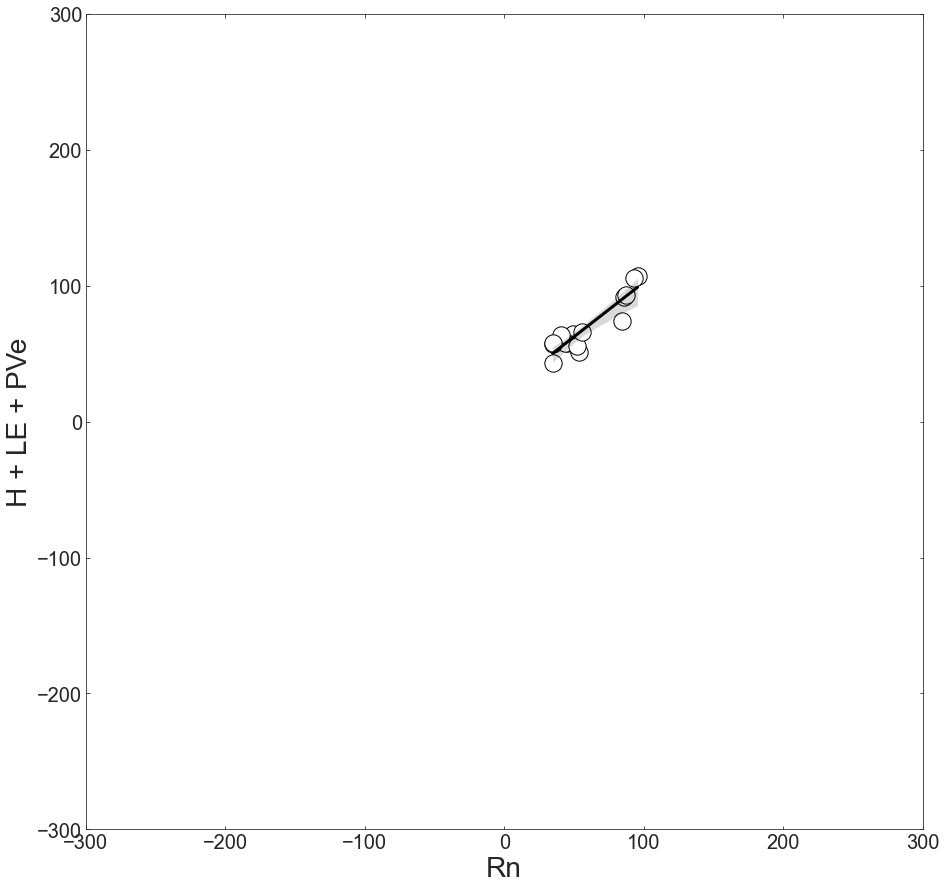

In [10]:
sns.set_style("ticks")
fig, axs = plt.subplots(ncols=1,nrows=1)
fig.set_size_inches(15, 15)
# control x and y limits
plt.ylim(-300, 300)
plt.xlim(-300, 300)
sns.set(font_scale = 1.8)
ax = sns.regplot(x='Rn_mean',y='H_LE_PVe_mean',marker="o",scatter_kws={"color":"white","alpha":1,"edgecolor":"black","s":300},line_kws={"color":"black","alpha":1,"lw":3},data=diurnal_mean_desert_df)
#sns.lmplot( x="Rn_mean", y="H_LE_PVe_mean", data=diurnal_mean_desert_df, hue='Month', legend=True)
ax.set_xlabel('Rn', fontsize=28)
ax.set_ylabel('H + LE + PVe',fontsize=28)
ax.tick_params(labelsize=20)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='both', direction = 'in',labeltop=False, labelright=False)

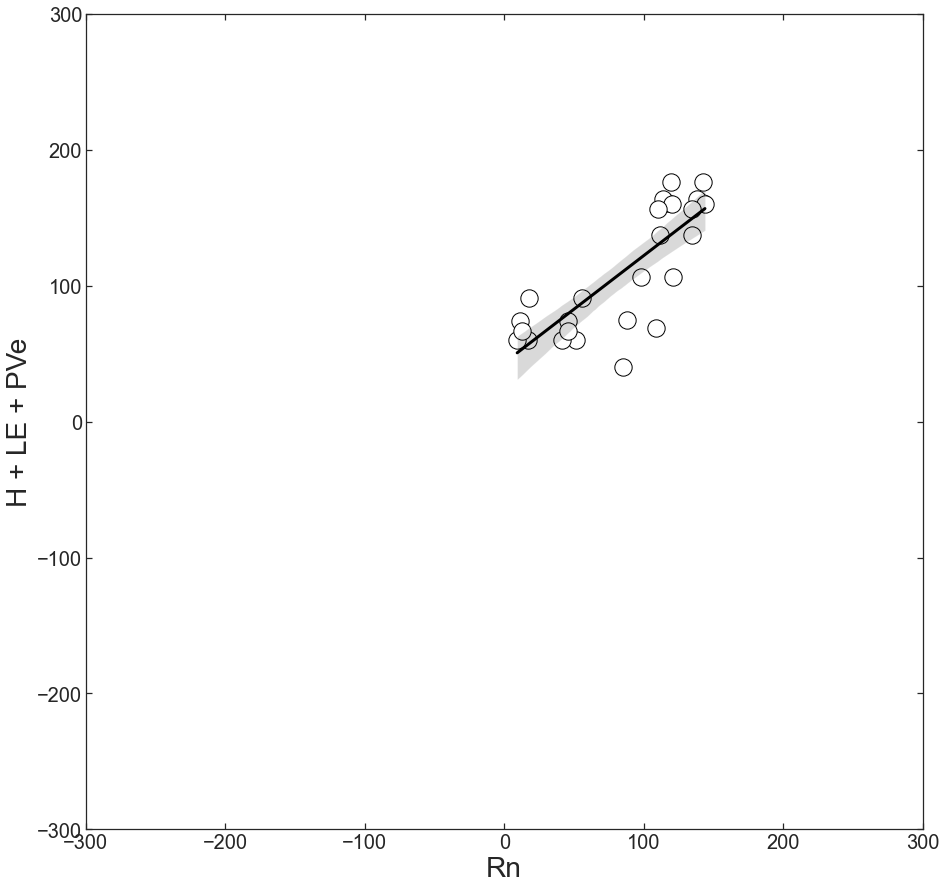

In [11]:
sns.set_style("ticks")
fig, axs = plt.subplots(ncols=1,nrows=1)
fig.set_size_inches(15, 15)
# control x and y limits
plt.ylim(-300, 300)
plt.xlim(-300, 300)
sns.set(font_scale = 1.8)
ax = sns.regplot(x='Rn_mean',y='H_LE_PVe_mean',marker="o",scatter_kws={"color":"white","alpha":1,"edgecolor":"black","s":300},line_kws={"color":"black","alpha":1,"lw":3},data=diurnal_mean_pv_df)
#sns.lmplot( x="Rn_mean", y="H_LE_PVe_mean", data=diurnal_mean_desert_df, hue='Month', legend=True)
ax.set_xlabel('Rn', fontsize=28)
ax.set_ylabel('H + LE + PVe',fontsize=28)
ax.tick_params(labelsize=20)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='both', direction = 'in',labeltop=False, labelright=False)

'Regression line: y_desert=22.36+0.80x_desert, r=0.91'

'Regression line: y_pv=43.27+0.79x_pv, r=0.81'

,Ecosystem,EBR spring,EBR summer,EBR autumn,slope,intercept,rvalue,pvalue,stderr,r_text,eq_text
0,Desert background,$EBR \;spring = 1.07$,$EBR \;summer = 1.06$,$EBR \;autumn = 1.44$,0.800382,22.363957,0.914132,1.874136e-06,0.098451,$R^2 = 0.91$,$y = 0.8x + 22.36$
0,PV field,$EBR \;spring = 0.65$,$EBR \;summer = 1.10$,$EBR \;autumn = 5.41$,0.788573,43.270554,0.807704,3.522745e-07,0.115125,$R^2 = 0.81$,$y = 0.79x + 43.27$


C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 19.0 x 10.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/03_graphs/ebr_mean.pdf
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\guides\guides.py:200: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 19.0 x 10.0 cm image.
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/03_graphs/ebr_mean.png
C:\Users\Rafaels\.conda\envs\analysis\lib\site-packages\plotnine\guides\guides.py:200: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to

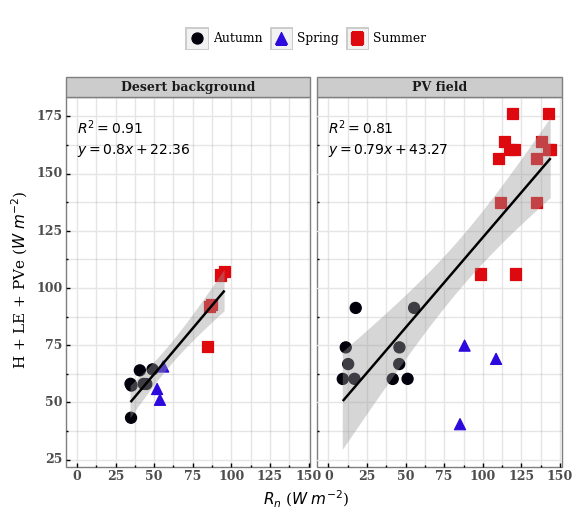

<ggplot: (-9223372004878982772)>

In [17]:
cbPalette = ["#02000B", "#2D09DE", "#DE090F", "#80ff80", "#c2c2d6", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

plt = ggplot(diurnal_mean_ketura_df)
plt = plt + theme_bw()
plt = plt + geom_point(aes(x='Rn_mean',y='H_LE_PVe_mean', shape='Season', color='Season'),size=4)
plt = plt + geom_smooth(aes(x='Rn_mean',y='H_LE_PVe_mean'),method='lm')
plt = plt + labs(x='$R_n$ ($W \; m^{-2}$)', y='H + LE + PVe ($W \; m^{-2}$)', parse=True)
plt = plt + facet_wrap(['Ecosystem'])
plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + scale_x_continuous(breaks=np.arange(-50,300,25))
plt = plt + scale_y_continuous(breaks=np.arange(-50,300,25))
plt = plt + theme(axis_text_x=element_text(size=9,weight='bold'),
                  axis_text_y=element_text(size=9,weight='bold'),
                  strip_text=element_text(size=9,weight='bold'),
                  legend_title=element_blank(),
                  text=element_text(family="serif"), 
                  axis_ticks_minor=element_line(size=1), axis_ticks_direction_y='in', axis_ticks_direction_x='in',
                  panel_grid_minor = element_line(size = 1,color='gray',alpha=0.2), panel_grid_major = element_line(size = 1))
plt = plt + theme(legend_position = 'top')
x_desert = diurnal_mean_desert_df['Rn_mean']
y_desert = diurnal_mean_desert_df['H_LE_PVe_mean']
slope, intercept, r, p, stderr = scipy.stats.linregress(x_desert, y_desert)
line_desert = f'Regression line: y_desert={intercept:.2f}+{slope:.2f}x_desert, r={r:.2f}'
#print(scipy.stats.linregress(x_desert,y_desert))
display(line_desert)

x_pv = diurnal_mean_pv_df['Rn_mean']
y_pv = diurnal_mean_pv_df['H_LE_PVe_mean']
slope, intercept, r, p, stderr = scipy.stats.linregress(x_pv, y_pv)
line_pv = f'Regression line: y_pv={intercept:.2f}+{slope:.2f}x_pv, r={r:.2f}'
#print(scipy.stats.linregress(x_pv,y_pv))
display(line_pv)

coefficients = pd.DataFrame([scipy.stats.linregress(x_desert, y_desert)])
coefficients = coefficients.append(pd.DataFrame([scipy.stats.linregress(x_pv, y_pv)]))
coefficients.insert(loc=0, column='Ecosystem', value=['Desert background','PV field'])
coefficients.insert(loc=1, column='EBR spring', value=['1.07','0.65'])
coefficients.insert(loc=2, column='EBR summer', value=['1.06','1.10'])
coefficients.insert(loc=3, column='EBR autumn', value=['1.44','5.41'])
#coefficients.insert(loc=1, column='EBR', value=[ebr_desert,'PV field'])
coefficients['r_text'] = '$R^2 = ' + coefficients['rvalue'].round(2).astype(str) + '$'
coefficients['eq_text'] = '$y = ' + coefficients['slope'].round(2).astype(str) + 'x + ' + coefficients['intercept'].round(2).astype(str) + '$'
coefficients['EBR spring'] = '$EBR \;spring = ' + coefficients['EBR spring'].astype(str) + '$'
coefficients['EBR summer'] = '$EBR \;summer = ' + coefficients['EBR summer'].astype(str) + '$'
coefficients['EBR autumn'] = '$EBR \;autumn = ' + coefficients['EBR autumn'].astype(str) + '$'
display(coefficients)

plt = plt + geom_text(aes(x=0, y = 170, label='r_text'), data=coefficients, inherit_aes=False, ha='left', size=10)
plt = plt + geom_text(aes(x=0, y = 160, label='eq_text'), data=coefficients, inherit_aes=False, ha='left', size=10)
# plt = plt + geom_text(aes(x=0, y = 160, label='EBR spring'), data=coefficients, inherit_aes=False, ha='left', size=10)
# plt = plt + geom_text(aes(x=0, y = 150, label='EBR summer'), data=coefficients, inherit_aes=False, ha='left', size=10)
# plt = plt + geom_text(aes(x=0, y = 140, label='EBR autumn'), data=coefficients, inherit_aes=False, ha='left', size=10)

#plt = plt + annotate('text', x=200, y = 8500, label='EBR')

plt.save(graphs_path + 'ebr_mean.pdf', width=19, height=10, units='cm', dpi=600)
plt.save(graphs_path + 'ebr_mean.png', width=19, height=10, units='cm', dpi=600)


plt

In [13]:
coefficients = pd.DataFrame([scipy.stats.linregress(x_desert, y_desert)])
coefficients = coefficients.append( pd.DataFrame([scipy.stats.linregress(x_pv, y_pv)]) )
coefficients.insert(loc=0, column='Ecosystem', value=['Desert background','PV field'])
display(coefficients)

,Ecosystem,slope,intercept,rvalue,pvalue,stderr
0,Desert background,0.800382,22.363957,0.914132,0.000002,0.098451
0,PV field,0.648325,50.050089,0.778366,0.000631,0.145033


In [14]:
solar_july_df = EBR_calc(all_df, 'Solar', 7)
solar_july_df.sum()

,DateTime,Season,Year,Ecosystem,H_LE_PVe,Rn


DateTime     0.0
Season       0.0
Year         0.0
Ecosystem    0.0
H_LE_PVe     0.0
Rn           0.0
dtype: float64

In [15]:
solar_october_df = EBR_calc(all_df, 'Solar', 10)
solar_october_df.sum()

,DateTime,Season,Year,Ecosystem,H_LE_PVe,Rn


DateTime     0.0
Season       0.0
Year         0.0
Ecosystem    0.0
H_LE_PVe     0.0
Rn           0.0
dtype: float64

In [16]:
solar_march_df = EBR_calc(all_df, 'Solar', 'March')
solar_march_df.sum()

,DateTime,Season,Year,Ecosystem,H_LE_PVe,Rn


DateTime     0.0
Season       0.0
Year         0.0
Ecosystem    0.0
H_LE_PVe     0.0
Rn           0.0
dtype: float64

In [17]:
desert_october_df = EBR_calc(all_df, 'Desert', 'October')
desert_october_df.sum()

,DateTime,Season,Year,Ecosystem,H_LE_PVe,Rn


DateTime     0.0
Season       0.0
Year         0.0
Ecosystem    0.0
H_LE_PVe     0.0
Rn           0.0
dtype: float64

In [18]:
desert_march_df = EBR_calc(all_df, 'Desert', 'March')
desert_march_df.sum()

,DateTime,Season,Year,Ecosystem,H_LE_PVe,Rn


DateTime     0.0
Season       0.0
Year         0.0
Ecosystem    0.0
H_LE_PVe     0.0
Rn           0.0
dtype: float64

In [19]:
desert_july_df = EBR_calc(all_df, 'Desert', 'July')
desert_july_df.sum()

,DateTime,Season,Year,Ecosystem,H_LE_PVe,Rn


DateTime     0.0
Season       0.0
Year         0.0
Ecosystem    0.0
H_LE_PVe     0.0
Rn           0.0
dtype: float64